## VQ-VAE MNIST

In [75]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='~/data', train=False, download=True, transform=transform)

# Create the data loaders
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [76]:
# Define the VQ-VAE encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, embedding_dim, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Define the VQ-VAE decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(embedding_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_size=1, stride=1)
        
    def forward(self, x):
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        x = self.deconv3(x)
        x = torch.tanh(x)
        return x


In [77]:
class Quantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(Quantizer, self).__init__()
        # codebook vectors 
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # w/o this line, training will not converge
        self.embedding.weight.data.uniform_(-1./num_embeddings, 1./num_embeddings)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
    def forward(self, z_e):
        # z_e - encoder latent code (B, C, H, W) -> (B, H, W, C)
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_shape = z_e.shape
        # flat version of z_e
        flat_z_e = z_e.view(-1, self.embedding_dim)

        # distance between z_e and embeddings
        distances = (torch.sum(flat_z_e**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_z_e, self.embedding.weight.t()))
        
        # minimal distance between z_e and embeddings
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z_e.device)
        # one-hot vector based on the minimal distance (eg 49 x 10-dimensional one-hot vectors)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        # N one-hot encodings quantizing/filtering by 0 or 1 each dim (col) of embedding
        # The encodings builds a map of which feature point of each feature embedding vector is used
        z_q = torch.matmul(encodings, self.embedding.weight).view(z_e_shape)
        
        # What is the purpose of z_q + (z_e - z_q).detach()?
        # Preserve gradients?
        z_q = z_e + (z_q - z_e).detach()
        
        # restore to original channel dimension
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q, encoding_indices

In [78]:
class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_embeddings):
        super(VQVAE, self).__init__()
        
        self.encoder = Encoder(input_dim, hidden_dim, embedding_dim)
        self.quantizer = Quantizer(num_embeddings, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, input_dim)
        
    def forward(self, x):
        # Encode the input
        z_e = self.encoder(x)
        
        # Quantize the encoded input
        z_q, indices = self.quantizer(z_e)
        
        # Decode the quantized input
        x_hat = self.decoder(z_q)
        
        return x_hat, z_e, z_q, indices


In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(1, 128, 64, 10).to(device)

In [80]:
random_input = torch.randn(1, 1, 28, 28).to(device)
z_e = model.encoder(random_input)
z_q, indeces = model.quantizer(z_e)
x_hat = model.decoder(z_q)
#x_hat, z_e, z_q, indices = model(random_input)

In [81]:
# Set the number of epochs
num_epochs = 10

# Create an optimizer
optimizer = optim.Adam(model.parameters())
# Print the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Train the model
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    r_loss = 0
    c_loss = 0
    l_loss = 0  
    total = 0 
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the data to the device
        data = data.to(device)
        total += data.size(0)
        
        # Forward pass
        x_hat, z_e, z_q, indices = model(data)
        recon_loss = nn.MSELoss()(x_hat, data)
        commit_loss = nn.MSELoss()(z_e.detach(), z_q)
        latent_loss = nn.MSELoss()(z_e, z_q.detach())
        loss = recon_loss + 0.2 * commit_loss + latent_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        r_loss += recon_loss.item()
        c_loss += commit_loss.item()
        l_loss += latent_loss.item()
    
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Ave Loss: {total_loss/total:.4f},\
        Recon Loss: {r_loss/total:.4f}, Commit Loss: {c_loss/total:.4f}, Latent Loss: {l_loss/total:.4f}")

Number of parameters: 666945


 10%|█         | 1/10 [00:09<01:24,  9.35s/it]

Epoch [1/10], Ave Loss: 0.0132,        Recon Loss: 0.0004, Commit Loss: 0.0106, Latent Loss: 0.0106


 20%|██        | 2/10 [00:18<01:13,  9.24s/it]

Epoch [2/10], Ave Loss: 0.0232,        Recon Loss: 0.0002, Commit Loss: 0.0191, Latent Loss: 0.0191


 30%|███       | 3/10 [00:27<01:04,  9.22s/it]

Epoch [3/10], Ave Loss: 0.0327,        Recon Loss: 0.0002, Commit Loss: 0.0271, Latent Loss: 0.0271


 40%|████      | 4/10 [00:36<00:55,  9.22s/it]

Epoch [4/10], Ave Loss: 0.0392,        Recon Loss: 0.0002, Commit Loss: 0.0325, Latent Loss: 0.0325


 50%|█████     | 5/10 [00:46<00:46,  9.27s/it]

Epoch [5/10], Ave Loss: 0.0464,        Recon Loss: 0.0002, Commit Loss: 0.0385, Latent Loss: 0.0385


 60%|██████    | 6/10 [00:55<00:36,  9.24s/it]

Epoch [6/10], Ave Loss: 0.0520,        Recon Loss: 0.0002, Commit Loss: 0.0432, Latent Loss: 0.0432


 70%|███████   | 7/10 [01:04<00:27,  9.22s/it]

Epoch [7/10], Ave Loss: 0.0537,        Recon Loss: 0.0002, Commit Loss: 0.0446, Latent Loss: 0.0446


 80%|████████  | 8/10 [01:13<00:18,  9.20s/it]

Epoch [8/10], Ave Loss: 0.0529,        Recon Loss: 0.0002, Commit Loss: 0.0439, Latent Loss: 0.0439


 90%|█████████ | 9/10 [01:23<00:09,  9.25s/it]

Epoch [9/10], Ave Loss: 0.0571,        Recon Loss: 0.0002, Commit Loss: 0.0474, Latent Loss: 0.0474


100%|██████████| 10/10 [01:32<00:00,  9.23s/it]

Epoch [10/10], Ave Loss: 0.0607,        Recon Loss: 0.0002, Commit Loss: 0.0504, Latent Loss: 0.0504


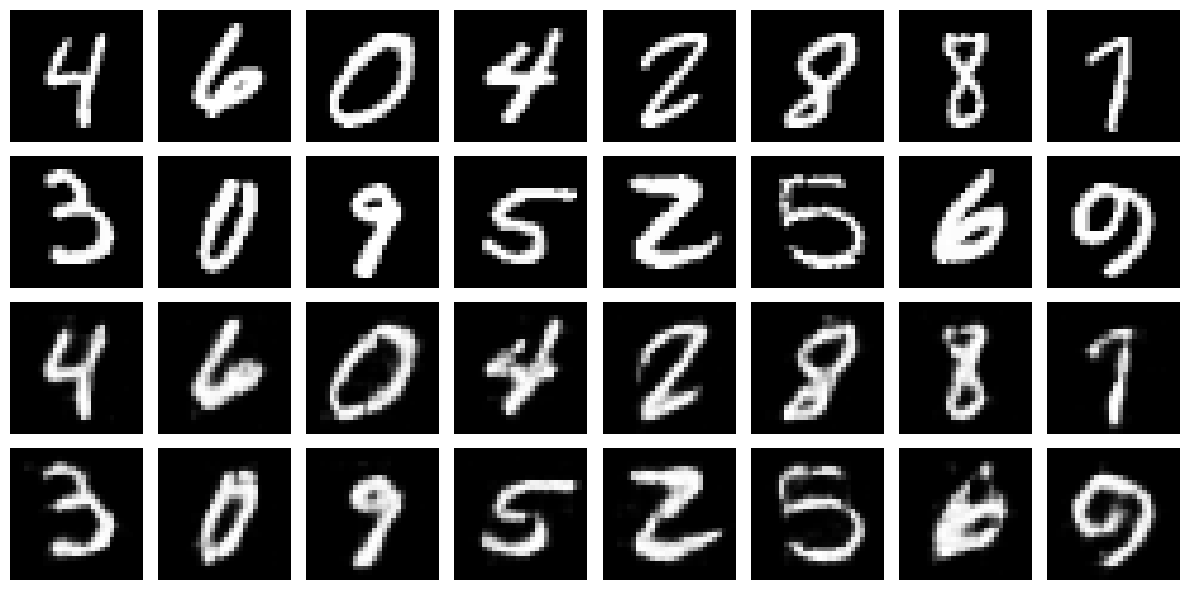

torch.Size([16, 64, 7, 7])
index: 1
tensor(-7.2635, device='cuda:0', grad_fn=<SumBackward0>)
index: 2
tensor(-6.4684, device='cuda:0', grad_fn=<SumBackward0>)
index: 3
tensor(-7.2977, device='cuda:0', grad_fn=<SumBackward0>)
index: 4
tensor(-7.8611, device='cuda:0', grad_fn=<SumBackward0>)
index: 5
tensor(-5.3653, device='cuda:0', grad_fn=<SumBackward0>)
index: 6
tensor(-9.1054, device='cuda:0', grad_fn=<SumBackward0>)
index: 7
tensor(-5.1085, device='cuda:0', grad_fn=<SumBackward0>)
index: 8
tensor(-4.6867, device='cuda:0', grad_fn=<SumBackward0>)
index: 9
tensor(-7.1445, device='cuda:0', grad_fn=<SumBackward0>)
index: 10
tensor(-4.9817, device='cuda:0', grad_fn=<SumBackward0>)
index: 11
tensor(-9.6027, device='cuda:0', grad_fn=<SumBackward0>)
index: 12
tensor(-6.9829, device='cuda:0', grad_fn=<SumBackward0>)
index: 13
tensor(-10.1071, device='cuda:0', grad_fn=<SumBackward0>)
index: 14
tensor(-3.3657, device='cuda:0', grad_fn=<SumBackward0>)
index: 15
tensor(-7.8205, device='cuda:0', 

In [82]:
import matplotlib.pyplot as plt

model.eval()

# Get 16 random samples from the test split
random_indices = torch.randint(0, len(test_dataset), (16,))
samples = [test_dataset[i][0] for i in random_indices]

# Move the samples to the device
samples = torch.stack(samples).to(device)

reconstructed_samples, _, _, _ = model(samples)

# Denormalize the samples
samples = (samples * 0.5) + 0.5
reconstructed_samples = (reconstructed_samples * 0.5) + 0.5

# Visualize the original and reconstructed images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for i in range(16):
    axes[i].imshow(samples[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i+16].imshow(reconstructed_samples[i].squeeze().detach().cpu(), cmap='gray')
    axes[i+16].axis('off')

plt.tight_layout()
plt.show()
x_hat, z_e, z_q, indices = model(samples)
print(z_q.shape)
for i in range(16):
    print(f"index: {i+1}")
    print(torch.sum(z_q[i]))


In [83]:
a = z_q[0]
b = z_q[8]
a = a.view(-1)
b = b.view(-1)
print(a)
print(b)
print(a.shape)
print(b.shape)
print(torch.sum(a))
print(torch.sum(b))

tensor([0.0582, 0.0582, 0.0582,  ..., 0.0667, 0.0055, 0.0055], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([ 0.0582,  0.0200, -0.0752,  ...,  0.0332,  0.0172,  0.0055],
       device='cuda:0', grad_fn=<ViewBackward0>)
torch.Size([3136])
torch.Size([3136])
tensor(-7.2635, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-7.1445, device='cuda:0', grad_fn=<SumBackward0>)
